In [73]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import gamma
import holoviews as hv
from decimal import Decimal
hv.extension('matplotlib')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [74]:
# Constants
h = 0.6727
H0=67.27
Omega_m = (0.1199)/(h**2)
Omega_b = 0.05
Omega_rad=10e-5
p_crit=4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T_0 = 2.7255
kb = 8.617333262145e-5
m_p=0.93827231
Y_p=0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
R_x_conversionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
# masses = np.array([])
# mass = 1e-6
# while(mass<1e3):
#     masses = np.append(masses,mass)
#     mass *= 1.5
sigma = np.zeros(len(masses))
sigma_array = np.logspace(100,-50,20)

---

## Numerical comparison via CLASS

In [200]:
npow_ = 0
masses_test = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigmas_test = np.logspace(-23,-33,100)

In [201]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',
              base_inis_path='class/inis/',
              class_runner_path = 'class/',
              npow=0,
              masses=masses_test,
              sigmas=sigmas_test,
              output_path='pk_output',
              sh_file='class/run_classes.sh'):
    
    sh_file = class_runner_path+'run_classes.sh'

    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    
    fout_sh = open(sh_file, 'w')

    for m in masses:
        for sigma in sigmas:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
            
            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')
            
            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [202]:
make_inis(npow=npow_)

In [203]:
def calculate_kcuts(npow=0, m=0.1, z='z1',sigmas=sigmas_test,
           pk_root='class/pk_output/', trust_cut=500,reduction_factor=0.25):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    khms = []
    ss = []
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        data = np.loadtxt(filename)
        
        pk = data[:,1]
        k_ = data[:,0]
        
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]<=trust_cut:
            khms.append(ks[ind])
            ss.append(sigmas[i])
    p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    return np.array(ss),np.array(khms),p

def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [204]:
sigmas_ref = np.logspace(-23,-33,1000)
for m in masses_test:
    ks_filename = 'ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

In [205]:
kcuts

array([7.64492880e-02, 8.58127340e-02, 9.22686054e-02, 1.02462489e-01,
       1.13447107e-01, 1.29629946e-01, 1.43137211e-01, 1.63288929e-01,
       1.80226352e-01, 2.05570715e-01, 2.34480802e-01, 2.67485899e-01,
       3.05291940e-01, 3.48950982e-01, 3.86536690e-01, 4.45430492e-01,
       5.19666522e-01, 5.93346374e-01, 6.59066926e-01, 7.52859331e-01,
       9.19698081e-01, 1.07511218e+00, 1.07511218e+00, 1.32269747e+00,
       1.66232821e+00, 1.66232821e+00, 2.09269241e+00, 2.63454345e+00,
       2.63454345e+00, 3.31669369e+00, 4.17546997e+00, 4.17546997e+00,
       5.25660525e+00, 5.25660525e+00, 6.61767393e+00, 8.33115788e+00,
       8.33115788e+00, 1.04883064e+01, 1.32039954e+01, 1.32039954e+01,
       1.66228454e+01, 2.09269224e+01, 2.09269224e+01, 2.63454345e+01,
       3.31669369e+01, 3.31669369e+01, 4.17546997e+01, 5.25660525e+01,
       5.25660525e+01, 6.61767393e+01, 6.61767393e+01, 6.61767393e+01,
       6.61767393e+01, 6.61767393e+01, 6.61767393e+01, 6.61767393e+01,
      

In [206]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))
    xmin = masses.min()
    xmax = masses.max()
    
    for i,m in enumerate(masses):
        ks_filename = 'ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                      
    return masses,sigmas

/home/maamari/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


(0.0001, 10)

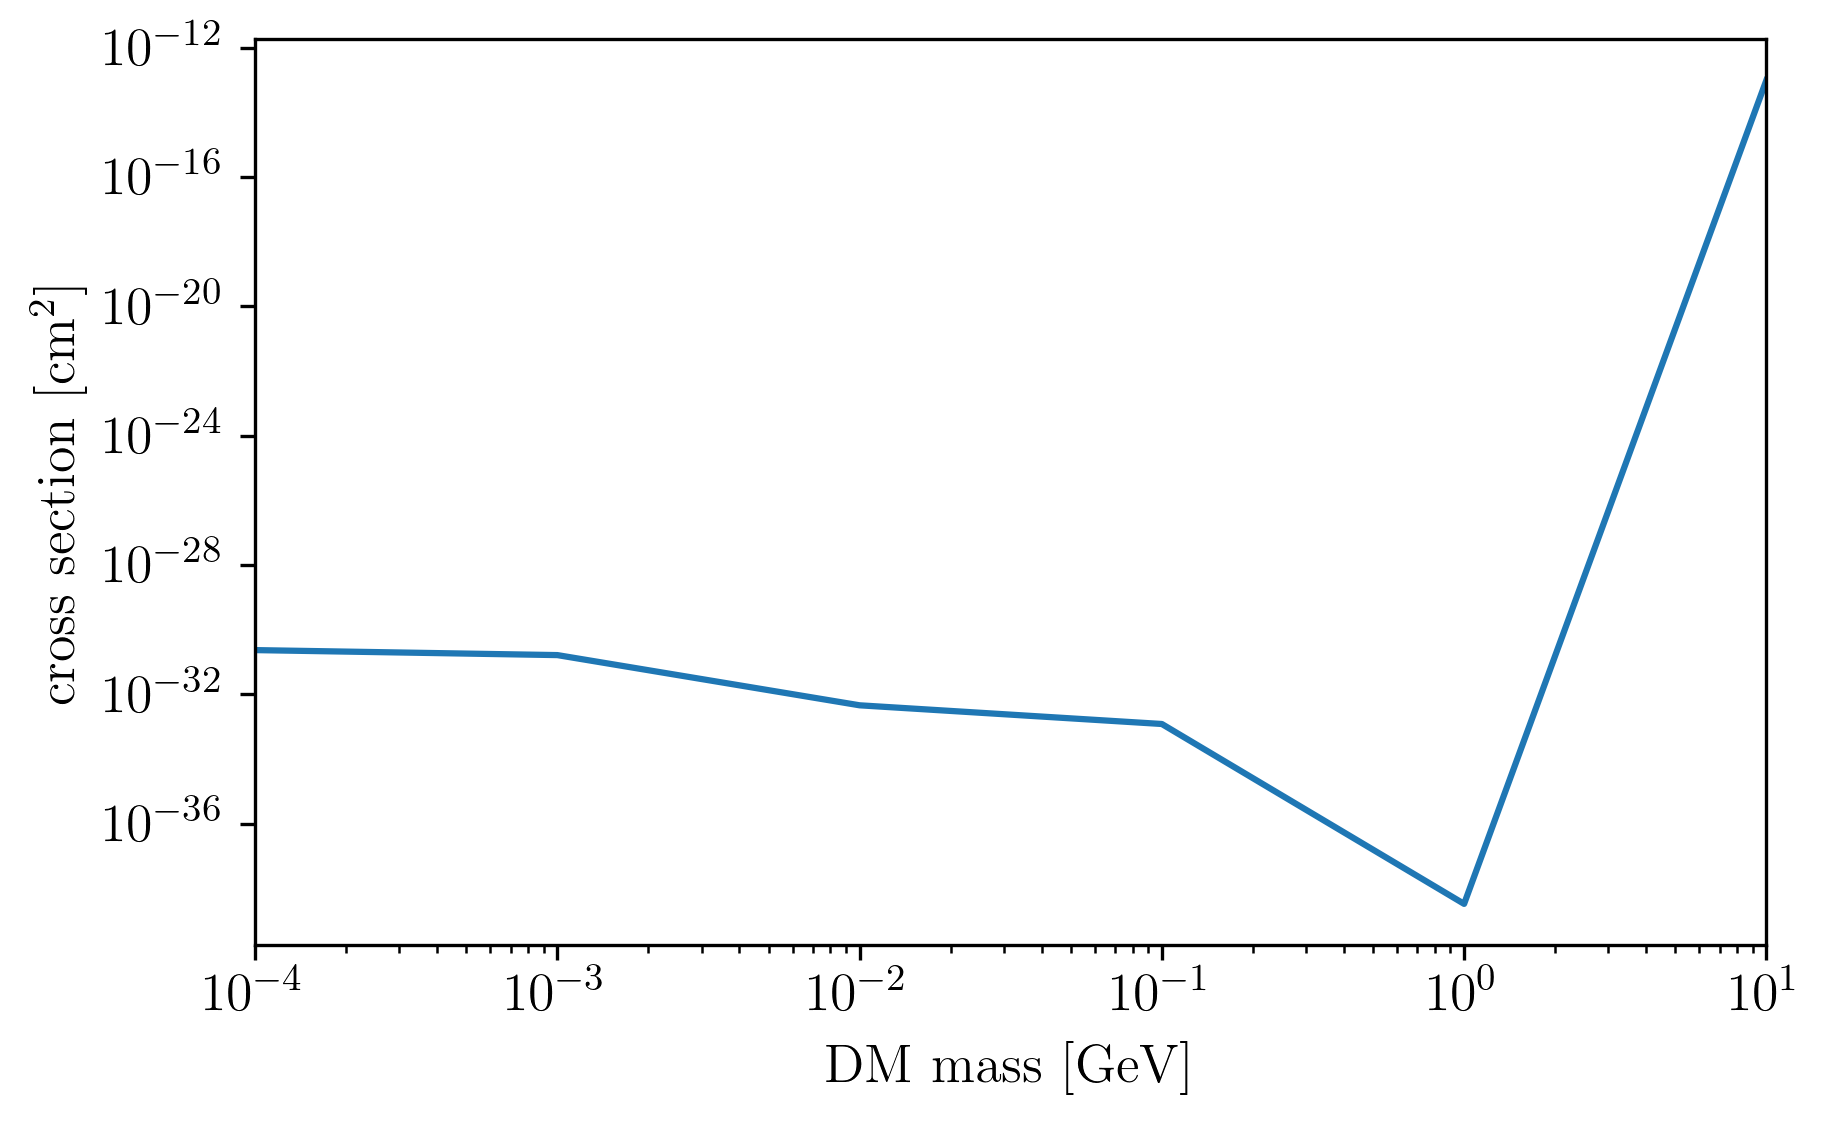

In [209]:
masses0,sigmas0=sigma0_limit(36,npow=0)
masses2,sigmas2=sigma0_limit(36,npow=2)
# masses4,sigmas4=sigma0_limit(36,npow=4)
# masses6,sigmas6=sigma0_limit(36,npow=6)

plt.loglog(masses0,sigmas0)
# plt.loglog(masses2,sigmas2)
# plt.loglog(masses4,sigmas4)
# plt.loglog(masses6,sigmas6)

plt.xlabel('DM mass [GeV]')
plt.ylabel(r'cross section [cm$^2$]')
plt.xlim(xmin=1e-4,xmax=10)
# plt.ylim(ymin=1e-40,ymax=1e-20)

(<Figure size 975x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fecb99d0ed0>)

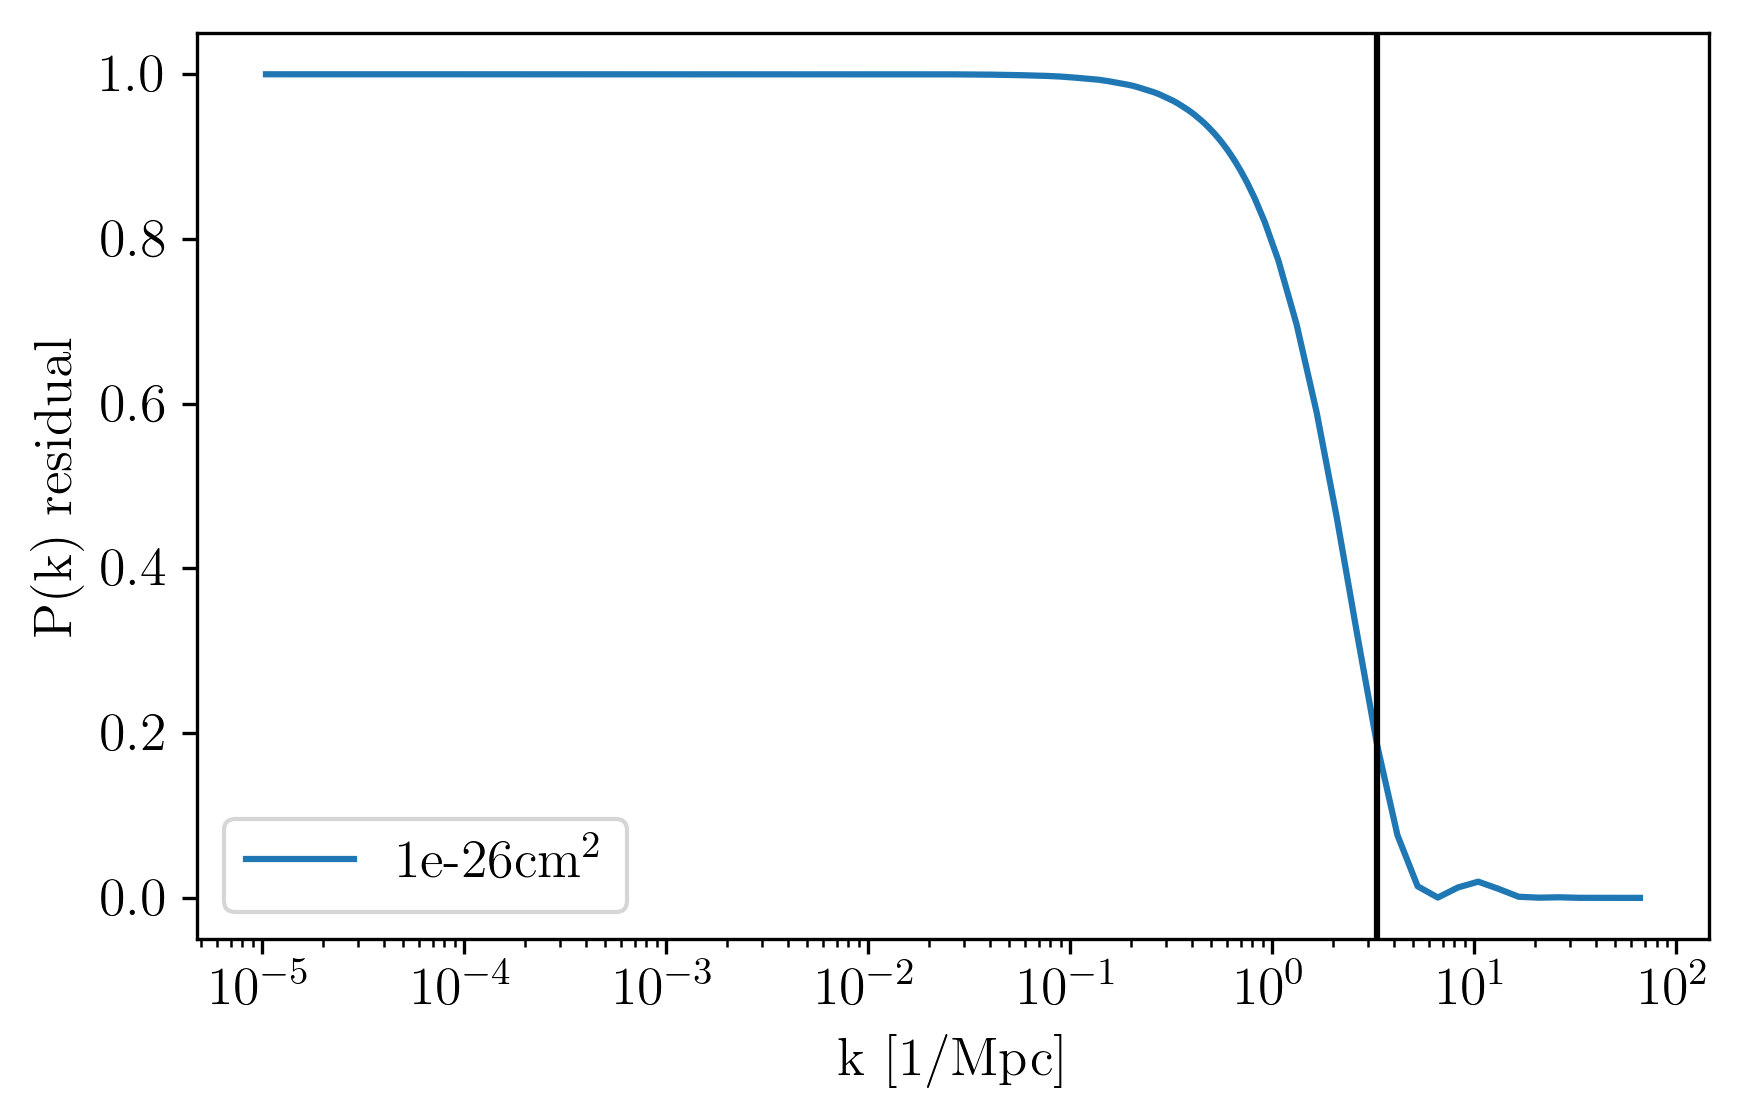

In [148]:
def show_pk(npow=0,m=masses_test[0],sigmas=sigmas_test,z='z1',
           pk_root='class/pk_output/',
            filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
           f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
           show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    """
    pfits = p, if you want to show the cuts
    """
    if (ax is None) or (f is None):
        f,ax = plt.subplots()
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    if filename is None:
        for i,sigma in enumerate(sigmas):
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
            data = np.loadtxt(filename)
            pk = data[:,1]
            ax.semilogx(ks,(pk)/pk0,label=r'{}cm$^2$'.format(sigma))
            plt.axvline(x=kcuts[i],color='k')
            break
    else:
        data = np.loadtxt(pk_root + filename)
        pk = data[:,1]
        if relative:
            ax.semilogx(ks,pk/pk0,label=label)
        else:
            ax.loglog(ks,pk*boost_factor,label=label)
    plt.legend()
    ax.set_xlabel('k [1/Mpc]')
    ax.set_ylabel('P(k) residual')
    
    f.show()
    return f,ax

show_pk(m=masses_test[4])